Naiwny klasyfikator bayesowski
---

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Zaczniemy od podziału przestrzeni z użyciem dwóch rodzajów naiwnego klasyfikatora bayesowskiego.

In [2]:
# losowe dane dla dwóch klas, przy przesunięciu środka rozkładu
train_data = np.vstack((np.random.normal(size=(100, 2), loc=5),
                        np.random.normal(size=(100, 2), loc=7)))
train_labels = np.hstack((np.zeros(100), np.ones(100)))

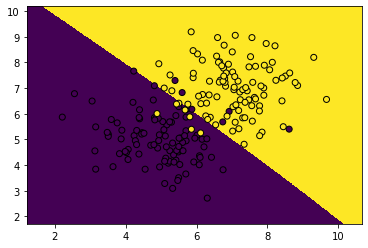

In [18]:
from datasets import plot_space  # do rysowania przestrzeni
from sklearn.naive_bayes import MultinomialNB, GaussianNB

# Gaussowski
plot_space(GaussianNB(), train_data, train_labels)

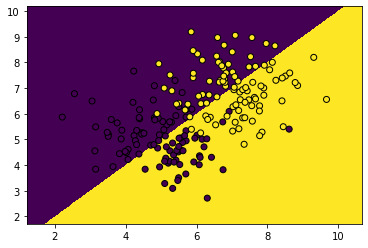

In [14]:
# Multinomialny
plot_space(MultinomialNB(), train_data, train_labels)

Analogicznie - dla danych liniowo nieseparowalnych

In [15]:
from sklearn.datasets.samples_generator import make_moons
X, y = make_moons(n_samples=100, noise=0.05)
# zwiększamy o 10 żeby wszystkie były dodatnie
X += 10

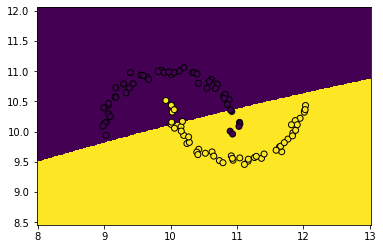

In [16]:
plot_space(GaussianNB(), X, y)

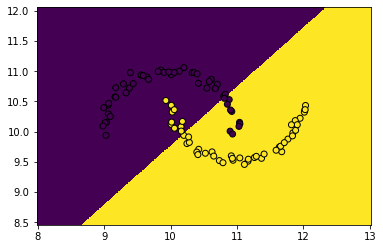

In [17]:
plot_space(MultinomialNB(), X, y)

Jak widać, multinomialny nie radzi sobie najlepiej. Wynika to z faktu, że wymaga on danych o cechach dyskretnych lub kategorycznych. Dlatego też konieczna jest tutaj dyskretyzacja. Omówimy 3 metody - o stałej szerokości przedziału, o starej częstości przykładów w przedziałach oraz metodę automatyczną.

In [22]:
def equal_length(column, n_bins):
    # metoda pandasa do podziału zbioru na jednakową długość
    indices, bins = pd.cut(column, n_bins, labels=False, retbins=True, duplicates='drop')
    return indices.map(dict(enumerate(bins)))

def equal_frequency(column, n_bins):
    # metoda pandasa do podziału zbioru na jednakową frekwencję (częstość)
    indices, bins = pd.qcut(column, n_bins, labels=False, retbins=True, duplicates='drop') 
    return indices.map(dict(enumerate(bins)))

def automatic_binning(column):
    # podział na przedziały zależy tu od histogramu
    _, bins = np.histogram(column, bins='fd')
    indices = pd.Series(np.digitize(column, bins) - 1)
    return indices.map(dict(enumerate(bins)))

# przykładowe postaci dla binningu - do użycia w metodzie apply
length_binning = lambda x: equal_length(x, 5)
freq_binning = lambda x: equal_frequency(x, 5)

Wczytamy sobie teraz dane dla zbioru glass i spróbujemy wykonać dyskretyzację.

In [19]:
from datasets import read_dataset  # do wczytywania zbiorów danych

X, y, classes = read_dataset('glass', 'Type', 'ID')

In [20]:
X.describe()

,refractive index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


In [30]:
binned = X.apply(length_binning)  # jak dla pozostałych metod dyskretyzacji?
for column in binned:
    display(binned[column].value_counts())

1.515706    156
1.520262     35
1.511127     15
1.524818      6
1.529374      2
Name: refractive index, dtype: int64

12.06000    112
13.39000     79
14.72000     15
10.72335      7
16.05000      1
Name: Sodium, dtype: int64

 2.69400    97
 3.59200    56
-0.00449    44
 1.79600    11
 0.89800     6
Name: Magnesium, dtype: int64

0.93200    125
1.57400     45
0.28679     28
2.21600     12
2.85800      4
Name: Aluminum, dtype: int64

72.0500    134
73.1700     37
70.9300     31
69.8044      8
74.2900      4
Name: Silicon, dtype: int64

-0.00621    207
 1.24200      4
 4.96800      2
 2.48400      1
Name: Potassium, dtype: int64

7.58200     169
9.73400      27
5.41924       9
11.88600      5
14.03800      4
Name: Calcium, dtype: int64

-0.00315    191
 1.26000     11
 0.63000      9
 2.52000      2
 1.89000      1
Name: Barium, dtype: int64

-0.00051    164
 0.10200     26
 0.20400     18
 0.30600      5
 0.40800      1
Name: Iron, dtype: int64

Zmodyfikujemy nieco naszą funkcję do walidacji krzyżowej, tak aby możliwa była dyskretyzacja danych.

In [83]:
from datasets import calculate_metrics, plot_cm, print_results
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def cross_validate(classifier, kfold, X, y,
                   binner=None, normalize=False,
                   params=None):
    if params is None:
        params = {}
    if binner is not None:
        X = X.apply(binner)
    if normalize:
        X[:] = MinMaxScaler().fit_transform(X.T).T
    predicted = []
    target = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf = classifier(**params).fit(X_train, y_train)
        predicted = np.concatenate((predicted,
                                    clf.predict(X_test)))
        target = np.concatenate((target,
                                 y_test))
    metrics = calculate_metrics(target, predicted)
    cm = confusion_matrix(target, predicted)
    return metrics, cm

Teraz wykonamy test dla obu klasyfikatorów. Możemy spróbować posterować naszymi parametrami.

Results for GNB
----
  Accuracy:  0.3644859813084112
  Precision: 0.45419371077265813
  Recall:    0.4948411264547701
  F1 score:  0.4436211041944465
  Mislabeled 136 out of 214




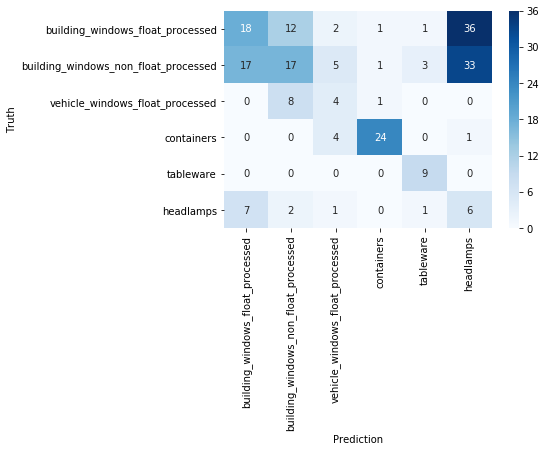

In [91]:
metrics, cm = cross_validate(GaussianNB, StratifiedKFold(9), X, y)
print_results(metrics, 'GNB')
plot_cm(cm, classes)

Results for MNB-none
----
  Accuracy:  0.5
  Precision: 0.2973292810249332
  Recall:    0.32951775991703397
  F1 score:  0.30929322535971765
  Mislabeled 107 out of 214




/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


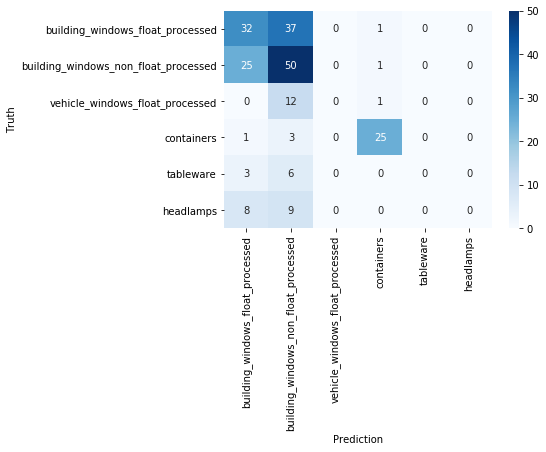

In [93]:
metrics, cm = cross_validate(MultinomialNB, StratifiedKFold(9), X, y, normalize=True, binner=None)
print_results(metrics, 'MNB-none')
plot_cm(cm, classes)

Results for MNB-automatic
----
  Accuracy:  0.46261682242990654
  Precision: 0.2863636363636364
  Recall:    0.27643246046149855
  F1 score:  0.2689567460944304
  Mislabeled 115 out of 214




/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


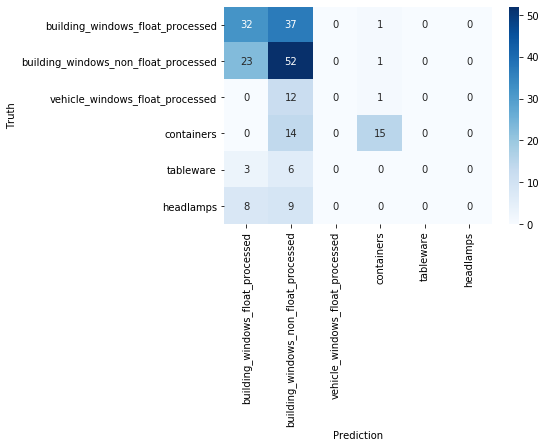

In [95]:
metrics, cm = cross_validate(MultinomialNB, StratifiedKFold(9), X, y, normalize=True, binner=automatic_binning)
print_results(metrics, 'MNB-automatic')
plot_cm(cm, classes)

Results for MNB-freq
----
  Accuracy:  0.48598130841121495
  Precision: 0.2961915535444947
  Recall:    0.3145147351136462
  F1 score:  0.29575026478830996
  Mislabeled 110 out of 214




/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


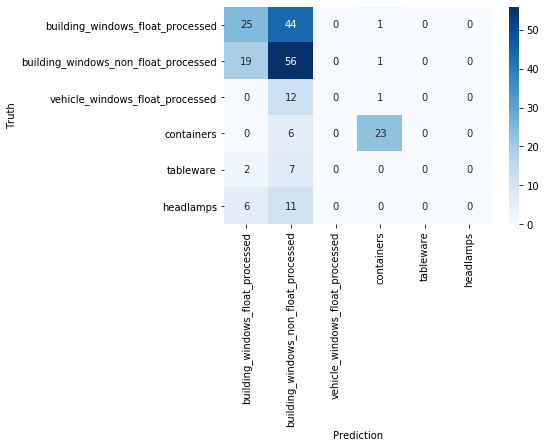

In [100]:
metrics, cm = cross_validate(MultinomialNB, StratifiedKFold(9), X, y, normalize=True, binner=lambda x: equal_frequency(x, 8))
print_results(metrics, 'MNB-freq')
plot_cm(cm, classes)

Results for MNB-len
----
  Accuracy:  0.5186915887850467
  Precision: 0.3051287679250805
  Recall:    0.3384776596664074
  F1 score:  0.31708909181056705
  Mislabeled 103 out of 214




/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


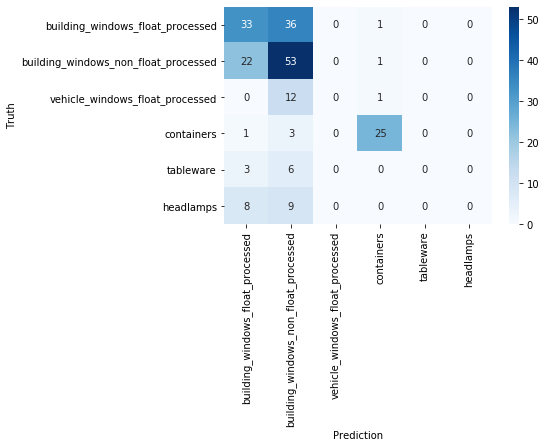

In [106]:
metrics, cm = cross_validate(MultinomialNB, StratifiedKFold(9), X, y, normalize=True, binner=lambda x: equal_length(x, 7))
print_results(metrics, 'MNB-len')
plot_cm(cm, classes)

In [111]:
def plot_results(result_df, title, plot_type='bar'):
    ind = np.arange(len(result_df))
    fig, ax = plt.subplots(figsize=(20, 10))
    width = 1 / len(result_df.columns)
    if plot_type == 'bar':
        plot = lambda index, data, label: ax.bar(index, data, width=width, label=label)
    elif plot_type == 'plot':
        plot = lambda index, data, label: ax.plot(index, data, label=label)
    plot(ind, result_df['accuracy'], 'Accuracy')
    plot(ind+width, result_df['precision'], 'Precision')
    plot(ind+2*width, result_df['recall'], 'Recall')
    plot(ind+3*width, result_df['fscore'], 'fscore')
    
    ax.set_title(title)
    ax.set_ylabel('Scores')
    ax.set_xlabel(result_df.index.name)
    ax.set_xticks(ind + 3 * width / 2)
    ax.set_xticklabels(result_df.index)
    ax.autoscale()
    ax.legend()
    return ax

def test_params(X, y, classifier, classifier_param, classifier_const_params=None,
                kfold=None,
                normalizer=None, binning=None):
    X = X.copy()
    if classifier_const_params is None:
        classifier_const_params = {}
    if kfold is None:
        kfold = StratifiedKFold(10)
    if normalizer is not None:
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X[:] = X_preprocessed
    if binning is not None:
        X_binned = X.apply(binning)
        X = X_binned
    param = list(classifier_param.keys())[0]
    data = {param: [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, value in enumerate(list(classifier_param.values())[0]):
        kwargs = {param: value}
        clf = classifier(**kwargs, **classifier_const_params)
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(clf,
                                     kfold,
                                     X, y,
                                     talk=False)
        data[param].append(value)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index(param)
    return plot_results(df, f'{clf.__class__.__name__} - {param}', plot_type='plot'), df

/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: 

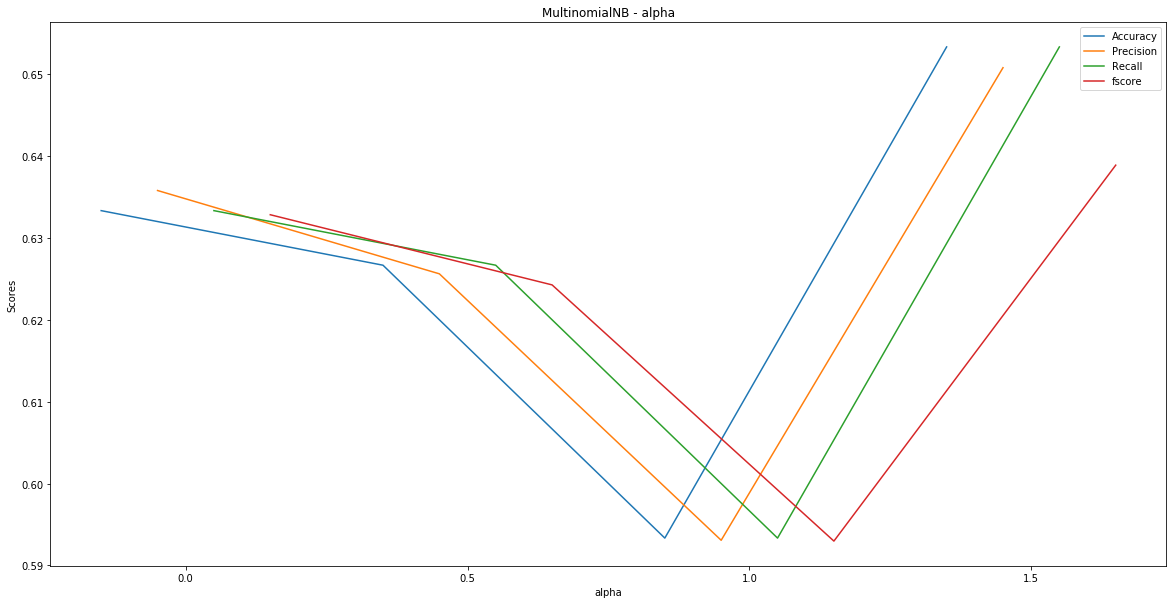

,accuracy,precision,recall,fscore,cm
alpha,,,,,
0.0,0.633333,0.635793,0.633333,0.632834,"[[49, 1, 0], [0, 19, 31], [0, 23, 27]]"
0.5,0.626667,0.625616,0.626667,0.624262,"[[50, 0, 0], [0, 18, 32], [0, 24, 26]]"
1.0,0.593333,0.593068,0.593333,0.592967,"[[50, 0, 0], [0, 18, 32], [0, 29, 21]]"
1.5,0.653333,0.650794,0.653333,0.638889,"[[50, 0, 0], [0, 34, 16], [0, 36, 14]]"


In [46]:
ax, results = test_params(X, y, MultinomialNB, {'alpha': np.arange(0, 2, 0.5)},
                         kfold=KFold(10, shuffle=True))
plt.show()
results

In [47]:
def test_classifiers(X, y, classifiers,
                     kfold=None,
                     normalizer=None, binning=None):
    X = X.copy()
    if kfold is None:
        kfold = StratifiedKFold(10)
    if normalizer is not None:
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X[:] = X_preprocessed
    if binning is not None:
        X_binned = X.apply(binning)
        X = X_binned
    data = {'classifier': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, classifier in enumerate(classifiers):
        name =  f"{classifier.__class__.__name__}-{index}"
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(classifier,
                                     kfold,
                                     X, y,
                                     talk=False)
        data['classifier'].append(name)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index('classifier')
    return plot_results(df, 'Classifiers comparison'), df

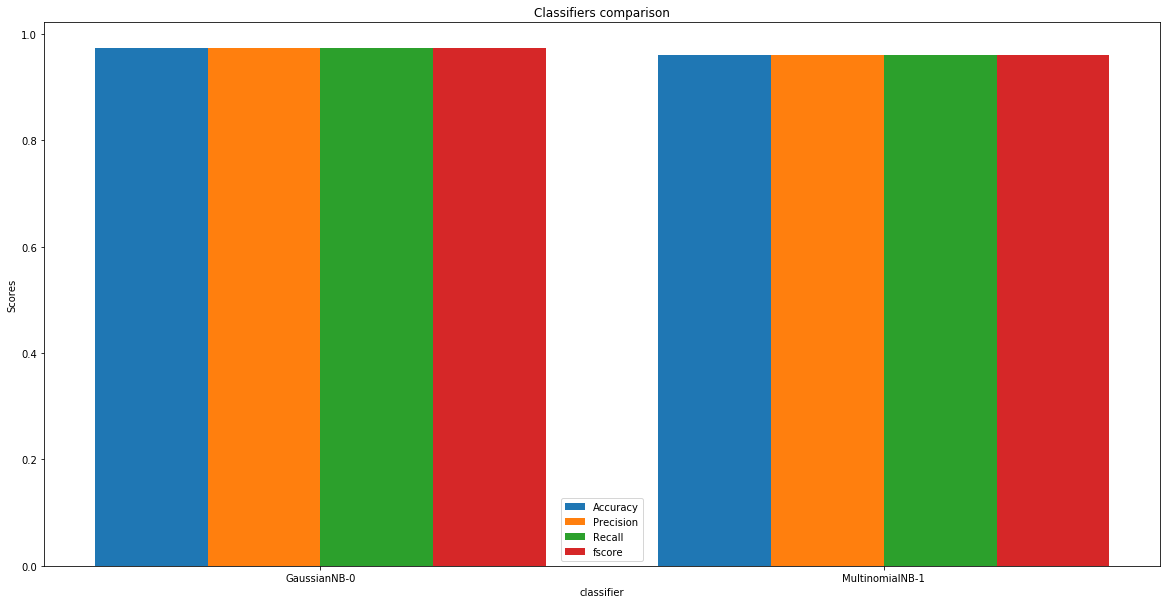

,accuracy,precision,recall,fscore,cm
classifier,,,,,
GaussianNB-0,0.973333,0.973825,0.973333,0.973323,"[[50, 0, 0], [0, 47, 3], [0, 1, 49]]"
MultinomialNB-1,0.960000,0.960470,0.960000,0.959984,"[[50, 0, 0], [0, 48, 2], [0, 4, 46]]"


In [57]:
ax, df = test_classifiers(X, y, [GaussianNB(), MultinomialNB()])
plt.show()
df

In [49]:
def test_folds(X, y, classifier, folds, kfold=None,
               normalizer=None, binning=None):
    X = X.copy()
    if kfold is None:
        kfold = StratifiedKFold
    if normalizer is not None:
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X[:] = X_preprocessed
    if binning is not None:
        X_binned = X.apply(binning)
        X = X_binned
    data = {'folds': folds,
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for n in folds:
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(classifier,
                                     kfold(n),
                                     X, y,
                                     talk=False)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index('folds')
    return plot_results(df, 'Number of folds', plot_type='plot'), df

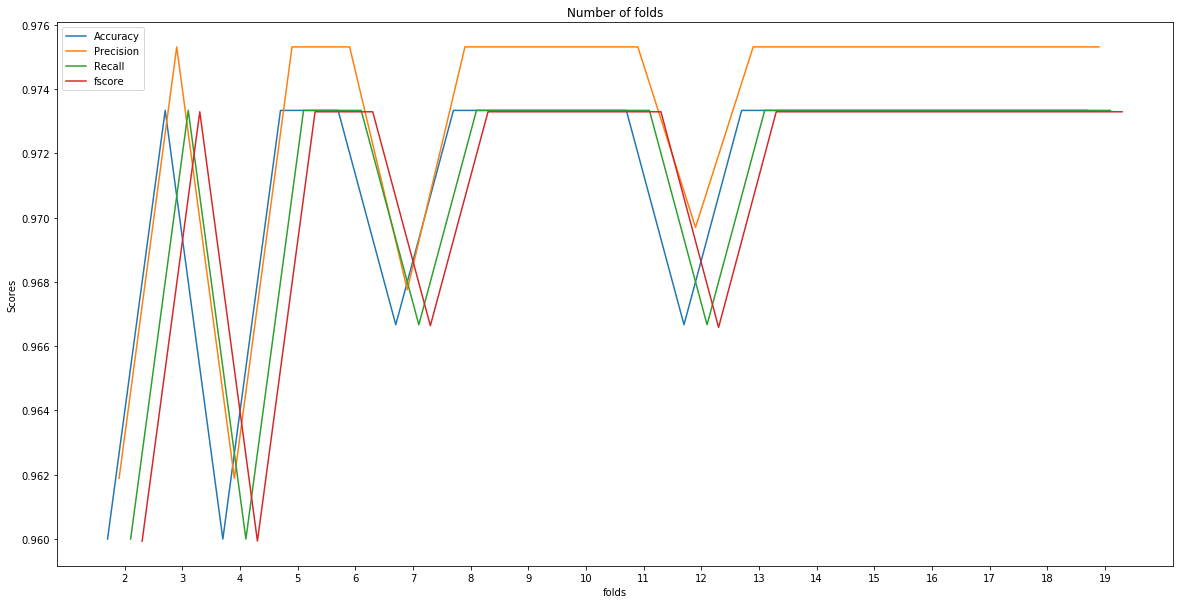

,accuracy,precision,recall,fscore,cm
folds,,,,,
2,0.960000,0.961889,0.960000,0.959936,"[[50, 0, 0], [0, 45, 5], [0, 1, 49]]"
3,0.973333,0.975309,0.973333,0.973291,"[[50, 0, 0], [0, 46, 4], [0, 0, 50]]"
4,0.960000,0.961889,0.960000,0.959936,"[[50, 0, 0], [0, 45, 5], [0, 1, 49]]"
5,0.973333,0.975309,0.973333,0.973291,"[[50, 0, 0], [0, 46, 4], [0, 0, 50]]"
6,0.973333,0.975309,0.973333,0.973291,"[[50, 0, 0], [0, 46, 4], [0, 0, 50]]"
7,0.966667,0.967751,0.966667,0.966637,"[[50, 0, 0], [0, 46, 4], [0, 1, 49]]"
8,0.973333,0.975309,0.973333,0.973291,"[[50, 0, 0], [0, 46, 4], [0, 0, 50]]"
9,0.973333,0.975309,0.973333,0.973291,"[[50, 0, 0], [0, 46, 4], [0, 0, 50]]"
10,0.973333,0.975309,0.973333,0.973291,"[[50, 0, 0], [0, 46, 4], [0, 0, 50]]"


In [50]:
ax, df = test_folds(X, y, GaussianNB, range(2,20,1), kfold=lambda x: KFold(x, shuffle=True))
plt.show()
df

In [51]:
def test_cross_val(X, y, classifier, kfolds,
               normalizer=None, binning=None):
    X = X.copy()
    if normalizer is not None:
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X[:] = X_preprocessed
    if binning is not None:
        X_binned = X.apply(binning)
        X = X_binned
    data = {'cross_val': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, kfold in enumerate(kfolds):
        name = f'{kfold.__class__.__name__}-{kfold.n_splits}_{index}'
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(classifier,
                                     kfold,
                                     X, y,
                                     talk=False)
        data['cross_val'].append(name)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index('cross_val')
    return plot_results(df, 'Cross-validation method'), df

/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


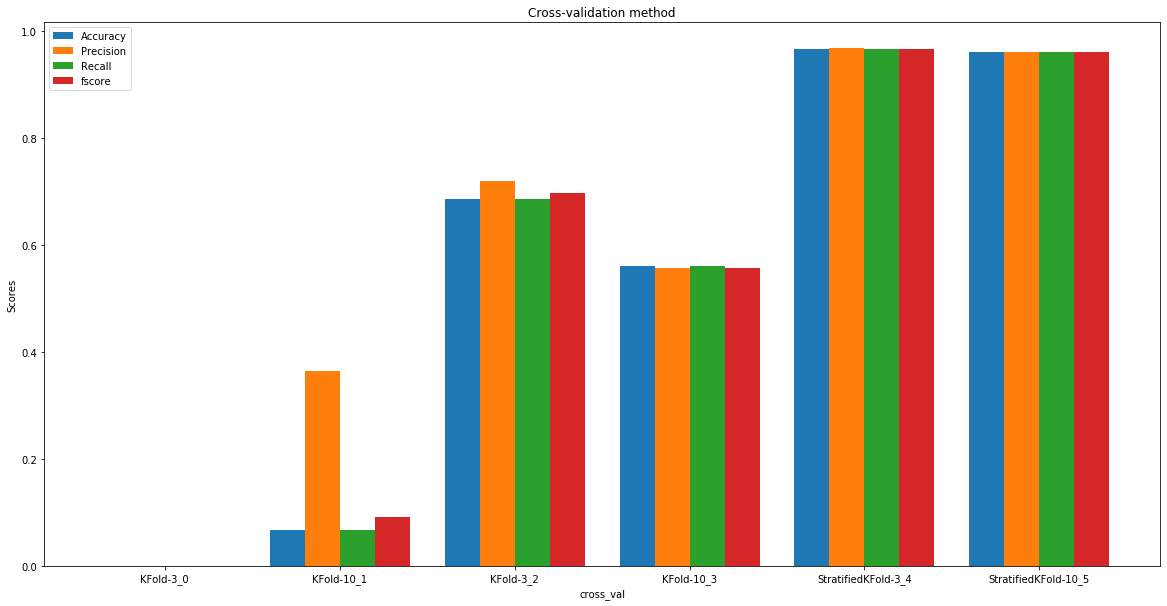

,accuracy,precision,recall,fscore,cm
cross_val,,,,,
KFold-3_0,0.000000,0.000000,0.000000,0.000000,"[[0, 50, 0], [0, 0, 50], [0, 50, 0]]"
KFold-10_1,0.066667,0.363636,0.066667,0.092352,"[[5, 45, 0], [0, 0, 50], [0, 45, 5]]"
KFold-3_2,0.686667,0.719081,0.686667,0.697243,"[[40, 10, 0], [0, 32, 18], [0, 19, 31]]"
KFold-10_3,0.560000,0.557198,0.560000,0.557166,"[[50, 0, 0], [0, 21, 29], [0, 37, 13]]"
StratifiedKFold-3_4,0.966667,0.967751,0.966667,0.966637,"[[50, 0, 0], [0, 49, 1], [0, 4, 46]]"
StratifiedKFold-10_5,0.960000,0.960470,0.960000,0.959984,"[[50, 0, 0], [0, 48, 2], [0, 4, 46]]"


In [58]:
ax, df = test_cross_val(X, y, MultinomialNB(), [KFold(3, False), KFold(10, False), KFold(3, True), KFold(10, True), StratifiedKFold(3), StratifiedKFold(10)])
plt.show()
df

In [113]:
def test_binning(X, y, classifier, binnings,
                       kfold=None, normalizer=None):
    X = X.copy()
    if kfold is None:
        kfold = StratifiedKFold(10)
    if normalizer is not None:
        normalizer.fit(X.T)
        X_preprocessed = normalizer.transform(X.T)
        X[:] = X_preprocessed.T
    data = {'binning': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, binning in enumerate(binnings):
        name = f'{binning.__name__}_{index}'
        X_binned = X.apply(binning)
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(classifier,
                                     kfold, X_binned, y)
        data['binning'].append(name)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index('binning')
    return plot_results(df, 'Binning method'), df

/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/piotrz/.miniconda3/envs/ds-training/lib/python3.7/site-packages/sklearn/

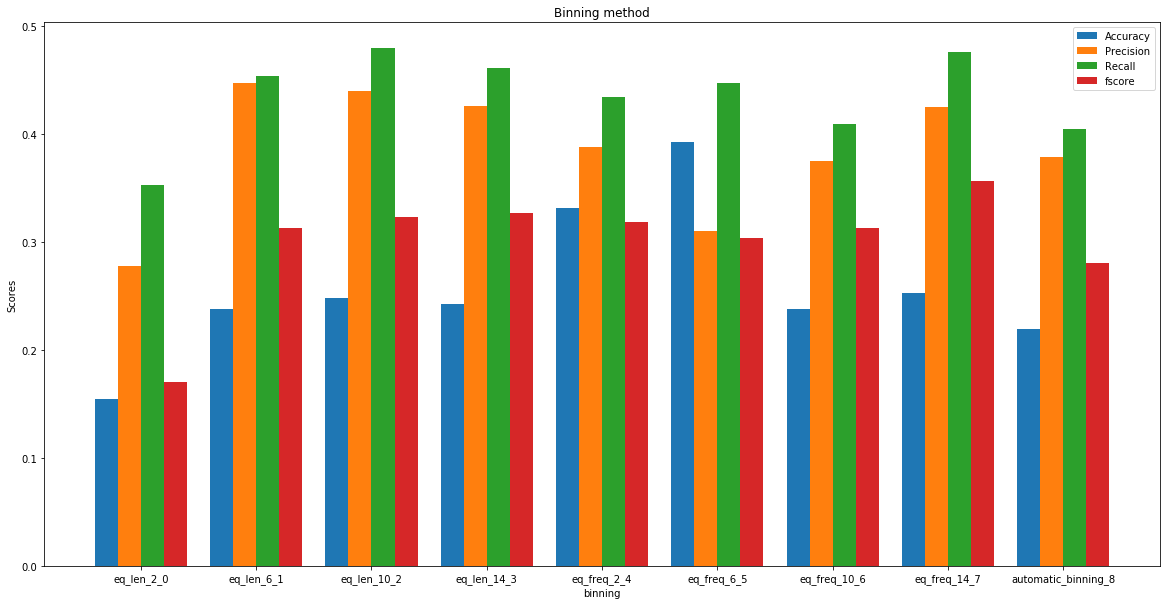

,accuracy,precision,recall,fscore,cm
binning,,,,,
eq_len_2_0,0.154206,0.277315,0.352349,0.170376,"[[4, 7, 3, 1, 14, 41], [6, 3, 12, 0, 10, 45], ..."
eq_len_6_1,0.238318,0.447567,0.454164,0.313084,"[[1, 1, 1, 1, 8, 58], [1, 3, 5, 1, 4, 62], [0,..."
eq_len_10_2,0.247664,0.439606,0.479470,0.323205,"[[1, 1, 1, 1, 5, 61], [1, 3, 4, 1, 6, 61], [0,..."
eq_len_14_3,0.242991,0.425614,0.460952,0.326840,"[[1, 1, 1, 1, 4, 62], [1, 3, 5, 1, 3, 63], [0,..."
eq_freq_2_4,0.331776,0.387655,0.434407,0.318880,"[[37, 5, 14, 1, 0, 13], [21, 10, 28, 1, 5, 11]..."
eq_freq_6_5,0.392523,0.310411,0.446798,0.303874,"[[54, 7, 4, 3, 2, 0], [43, 10, 21, 0, 1, 1], [..."
eq_freq_10_6,0.238318,0.374759,0.408817,0.312923,"[[5, 7, 2, 1, 4, 51], [7, 6, 2, 1, 1, 59], [0,..."
eq_freq_14_7,0.252336,0.424924,0.476315,0.356749,"[[0, 0, 3, 2, 1, 64], [1, 4, 4, 1, 1, 65], [0,..."
automatic_binning_8,0.219626,0.378363,0.404445,0.280702,"[[4, 8, 1, 1, 11, 45], [6, 7, 2, 1, 6, 54], [0..."


In [115]:
def eq_len_2(x): return equal_length(x, 2)
def eq_len_6(x): return equal_length(x, 6)
def eq_len_10(x): return equal_length(x, 10)
def eq_len_14(x): return equal_length(x, 14)

def eq_freq_2(x): return equal_frequency(x, 2)
def eq_freq_6(x): return equal_frequency(x, 6)
def eq_freq_10(x): return equal_frequency(x, 10)
def eq_freq_14(x): return equal_frequency(x, 14)

ax, df = test_binning(X, y, GaussianNB, [eq_len_2,
                                         eq_len_6,
                                         eq_len_10,
                                         eq_len_14,
                                         eq_freq_2,
                                         eq_freq_6,
                                         eq_freq_10,
                                         eq_freq_14,
                                         automatic_binning])
plt.show()
df